In [1]:
import sys
import os

import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from matplotlib import pylab as plt
from scipy.spatial.distance import squareform
from numpy import save
from numpy import load
import random

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

sns.set_style('ticks')
sns.set_context('talk')

%run Funx_Simon.py
%run Classifier_Funx.py

# Load Data

In [2]:
#Option 3: All mice all planes

FOLDER_PATH_plane_0 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#163/Analysis/Plane_0"
FOLDER_PATH_plane_1 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#163/Analysis/Plane_1"
FOLDER_PATH_plane_2 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#163/Analysis/Plane_2"
FOLDER_PATH_plane_3 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#164/Analysis/Plane_0"
FOLDER_PATH_plane_4 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#164/Analysis/Plane_2"
FOLDER_PATH_plane_5 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#8/Analysis/Plane_0"
FOLDER_PATH_plane_6 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#8/Analysis/Plane_2"
FOLDER_PATH_plane_7 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#9/Analysis/Plane_0"
FOLDER_PATH_plane_8=  "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#9/Analysis/Plane_1"
FOLDER_PATH_plane_9 = "/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_2/Mouse#9/Analysis/Plane_2"

filteredDataArraypath_0 = os.path.join(FOLDER_PATH_plane_0, "filteredDataArray.npy")
filteredDataArraypath_1 = os.path.join(FOLDER_PATH_plane_1, "filteredDataArray.npy")
filteredDataArraypath_2 = os.path.join(FOLDER_PATH_plane_2, "filteredDataArray.npy")
filteredDataArraypath_3 = os.path.join(FOLDER_PATH_plane_3, "filteredDataArray.npy")
filteredDataArraypath_4 = os.path.join(FOLDER_PATH_plane_4, "filteredDataArray.npy")
filteredDataArraypath_5 = os.path.join(FOLDER_PATH_plane_5, "filteredDataArray.npy")
filteredDataArraypath_6 = os.path.join(FOLDER_PATH_plane_6, "filteredDataArray.npy")
filteredDataArraypath_7 = os.path.join(FOLDER_PATH_plane_7, "filteredDataArray.npy")
filteredDataArraypath_8 = os.path.join(FOLDER_PATH_plane_8, "filteredDataArray.npy")
filteredDataArraypath_9 = os.path.join(FOLDER_PATH_plane_9, "filteredDataArray.npy")

filteredDataArray0 = load(filteredDataArraypath_0)
filteredDataArray1 = load(filteredDataArraypath_1)
filteredDataArray2 = load(filteredDataArraypath_2)
filteredDataArray3 = load(filteredDataArraypath_3)
filteredDataArray4 = load(filteredDataArraypath_4)
filteredDataArray5 = load(filteredDataArraypath_5)
filteredDataArray6 = load(filteredDataArraypath_6)
filteredDataArray7 = load(filteredDataArraypath_7)
filteredDataArray8 = load(filteredDataArraypath_8)
filteredDataArray9 = load(filteredDataArraypath_9)

filteredDataArray = np.concatenate((filteredDataArray0, filteredDataArray1, filteredDataArray2, filteredDataArray3, filteredDataArray4, filteredDataArray5, filteredDataArray6, filteredDataArray7, filteredDataArray8, filteredDataArray9), axis = 0)


In [3]:
#Need to remove first point of each trials for odorset2
filteredDataArray = filteredDataArray[:,:,:,1:136]

# Calculate response matrix

In [22]:
#Make matrices of resp after odor onset (choose baseline and odor window)

inputArrayForResps = filteredDataArray.transpose(1,0,2,3)
resps = getRespsRegular(inputArrayForResps, numTrialsToKeep=8, blinewin =[10,15], odorwin = [45,60])


# Classifier parameters

In [23]:
NumberOdor = 8
NumberTrials = 8
Control1=0
Control2=1

xx = np.arange(0,NumberOdor)
yy = np.ones((1,NumberTrials),dtype=np.int32)
zz = np.kron(xx,yy)
z = zz.transpose(1,0)

In [24]:
# To use for shuffle control 

# np.random.shuffle(z)

In [25]:
#Get Mean response arrays for each time window

inputArrayForRespsClass = filteredDataArray.transpose(1,0,2,3)

stepsize = 3
respsbaserolling = []

for i in range (135):
    respsbase = MeanResp(inputArrayForRespsClass, numTrialsToKeep=8, win = [i,i+stepsize])
    respsbaserolling.append(respsbase[None])
respsbaserolling=np.concatenate(respsbaserolling,0)

respsbaserolling.shape

(135, 8, 924, 10)

In [26]:
#Rolling window array: Drop Controls and reshape trials x stim into one feature dimension 
respsbasenocontrol = respsbaserolling[:,:,:,2:10]
# respsbasenocontrol = respsbaserolling[:,:,:,Control1+1:Control2]
respsbaseclas= respsbasenocontrol.transpose (3,1,2,0)

respsbaseclass = respsbaseclas.reshape(-1, respsbaseclas.shape[-2],respsbaseclas.shape[-1])
respsbaseclass.shape

(64, 924, 135)

In [27]:
#PostStimulus array: Drop Controls and reshape trials x stim into one feature dimension 
respsnocontrol = resps[:,:,2:10]
# respsnocontrol = respsGreen[:,:,Control1+1:Control2]
respsclas= respsnocontrol.transpose (2,0,1)

respsclass = respsclas.reshape(-1, respsclas.shape[-1])
respsclass.shape

(64, 924)

In [28]:
X = respsclass
Xz = respsbaseclass
y= z

In [29]:
Xz.shape

(64, 924, 135)

# Confusion Matrix

Text(97.52000000000001, 0.5, 'presented stimulus')

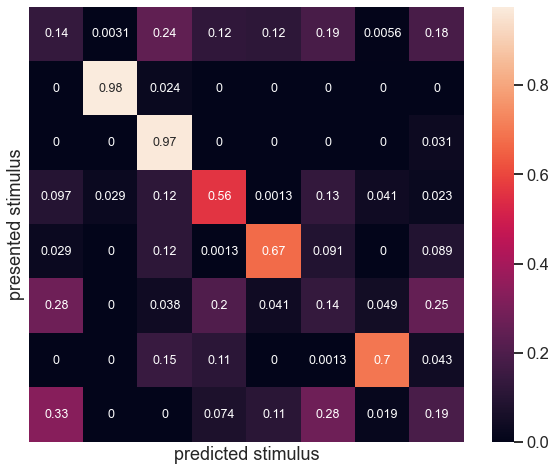

In [30]:
confusion = ConfusionMatrix(X, y, n_splits=8, n_repeats=200)

plt.figure(figsize=(10,8))
sns.heatmap(confusion, square = True, xticklabels=[], yticklabels=[], annot=True, annot_kws=dict(fontsize='x-small'))
plt.xlabel('predicted stimulus')
plt.ylabel('presented stimulus')

# Run SVM with sliding window

In [33]:
Odorscore, Odornomeanscore= SVModor(X=X, y=y, n_splits= 8, n_repeats= 50)

In [34]:
Odornomeanscore

0.544375

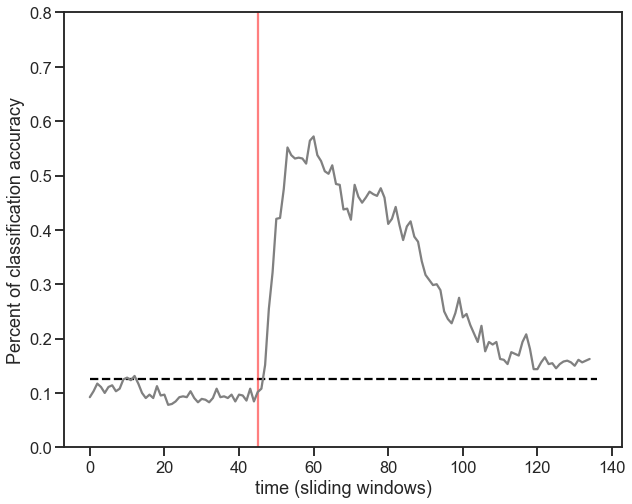

In [19]:
swinscore, swinnomeanscore= SVMslidewindow(X=X, Xz=Xz, y=y, Numslidewin= 135, n_splits= 8, n_repeats= 10)

plt.figure(figsize=(10,8))
sns.lineplot(data=swinscore, color = 'grey')
plt.xlabel('time (sliding windows)')
plt.ylabel('Percent of classification accuracy')
plt.ylim(0,0.8)
plt.hlines(0.125,0,136, linestyles='dashed')
plt.vlines(45,0,1, color='r', alpha=0.5)

# Run SVM with random selection of cells

In [63]:
swintestt=[]
swintest =[]

for l in range (100): #l is the number of time to randomize the cell population
    swintest.append(SVMrandselectcells (X=X, y=y, numcells=50, n_splits=8, n_repeats=5)[None])
swintestt=np.concatenate(swintest,0)


Text(0, 0.5, 'Percent of classification accuracy')

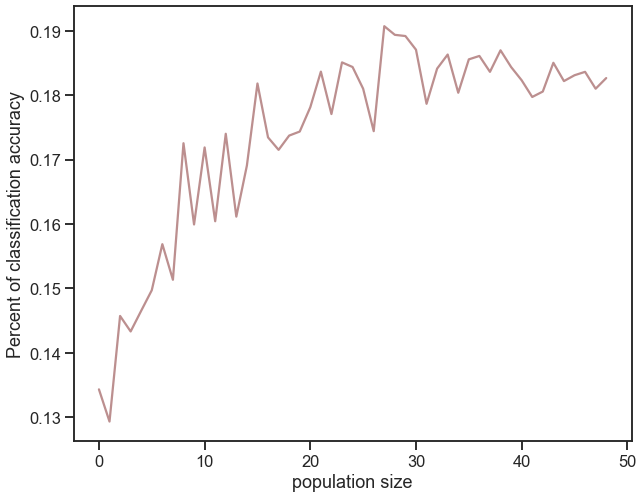

In [64]:
plt.figure(figsize=(10,8))
sns.lineplot(data=swintestt.mean(0), color = 'rosybrown')
plt.xlabel('population size')
plt.ylabel('Percent of classification accuracy')

In [83]:
swintesttGreenn = swintesttGreen.transpose(1,0)
swintesttRedd = swintesttRed.transpose(1,0)
dataframe1 = PlotMeanwConfidence(array=swintesttGreenn)
dataframe2 = PlotMeanwConfidence(array=swintesttRedd)
plt.figure(figsize=(10,8))
sns.lineplot(x="x", y="Dff", data=dataframe1, color = 'mediumseagreen')
sns.lineplot(x="x", y="Dff", data=dataframe2, color = 'firebrick')
plt.xlabel('population size')
plt.ylabel('Percent of classification accuracy')
plt.ylim(0.1,0.30)
plt.hlines(0.125,0,50, linestyles='dashed')
FOLDER_PATH = '/Users/sdaste/Desktop/LAB/MEETINGS/20210118_Lab_Meeting/PNG'
path22 = os.path.join(FOLDER_PATH, "SVM_pop_Green_Red.pdf")
plt.savefig(path22, transparent = True, dpi = 600, bbox_inches='tight')